# Assignment 2 - Sentiment Analysis and Classification Algorithms
#### Jose Manuel Vera Aray

### Import libraries to be used

In [2]:
import numpy as np
import itertools
import math
import pandas as pd
import csv
import time
from sklearn.cross_validation import train_test_split, KFold
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.model_selection import learning_curve
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix
from sklearn.grid_search import GridSearchCV
from sklearn.utils import shuffle
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid", color_codes=True)

/resources/common/.virtualenv/python3/lib/python3.4/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/resources/common/.virtualenv/python3/lib/python3.4/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


### Import training data

In [3]:
with open("/resources/data/classified_tweets.txt", "r",encoding="utf8") as myfile:
     data = myfile.readlines()

### Separate tweets into two sets: tweet data and its respective classification

In [4]:
X=[]
y=[]
for x in data:
    X.append(x[1:])
    y.append(x[0])

### Split the data into the training set and test set for crossvalidation

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=42, test_size = 0.3)

### Create a pipeline for each classifier algorithm

.....vectorizer => transformer => classifier

In [6]:
#Logistic Regression
Log_clf=Pipeline([('vect', CountVectorizer(analyzer='word')), ('tfidf', TfidfTransformer()), ('clf', LogisticRegression())])
#Multinomial Naive Bayes
MNB_clf=Pipeline([('vect', CountVectorizer(analyzer='word')), ('tfidf', TfidfTransformer()), ('clf', MultinomialNB())])

### Parameter tuning

We will use GridSearchCV, which exhaustively considers all parameter combinations, to find the best model for the data. A search consists of:
- an estimator (regressor or classifier )
- a parameter space;
- a method for searching or sampling candidates;
- a cross-validation scheme; 
- a score function, such as accurracy_score()

Set parameters we will test for each algorithm

In [7]:
parameters_log = {'vect__ngram_range': [(1, 1), (1, 2)],'tfidf__use_idf': (True, False), 'clf__penalty': ['l1','l2'], 'clf__solver':['liblinear']}
parameters_mnb = {'vect__ngram_range': [(1, 1), (1, 2)],'tfidf__use_idf': (True, False),'clf__alpha': (1,1e-2, 1e-3)}

Set models and do the search of the parameter

In [8]:
#Set models
acc_scorer = make_scorer(accuracy_score)
gs_log_clf = GridSearchCV(Log_clf, parameters_log, n_jobs=-1, scoring=acc_scorer)
gs_mnb_clf = GridSearchCV(MNB_clf, parameters_mnb, n_jobs=-1, scoring=acc_scorer)
# Grid search of best parameters
print ("-----Tunning of parameters-----")
start = time.time()
gs_log_clf = gs_log_clf.fit(X_train, y_train)
end = time.time()
print ("Logistic Regression -"," Running Time:", end - start,"s")
start = time.time()
gs_mnb_clf= gs_mnb_clf.fit(X_train, y_train)
end = time.time()
print ("Multinomial Naive Bayes -"," Running Time:", end - start,"s")

-----Tunning of parameters-----
Logistic Regression -  Running Time: 50.627103328704834 s
Multinomial Naive Bayes -  Running Time: 47.09324789047241 s


Set the classifiers to the have the best combination of parameters

In [9]:
Log_clf= gs_log_clf .best_estimator_
MNB_clf= gs_mnb_clf .best_estimator_

### Train algorithms

In [10]:
start = time.time()
Log_clf = Log_clf.fit(X_train, y_train)
end = time.time()
print ("Logistic Regression -"," Running Time:", end - start,"s")
start = time.time()
MNB_clf = MNB_clf.fit(X_train, y_train)
end = time.time()
print ("Multinomial Naive Bayes -"," Running Time:", end - start,"s")

Logistic Regression -  Running Time: 18.095815181732178 s
Multinomial Naive Bayes -  Running Time: 13.500214576721191 s


## Predict on the test set and check metrics

In [11]:
predicted_Log = Log_clf.predict(X_test)
predicted_MNB =MNB_clf.predict(X_test)
dec_Log = Log_clf.decision_function(X_test)
dec_MNB =MNB_clf.predict_proba(X_test)

#### Perform k-fold

In [12]:
def run_kfold(clf):
    
    #run KFold with 10 folds instead of the default 3
    #on the 200000 records in the training_data
    kf = KFold(200000, n_folds=10,shuffle=True)
    X_new=np.array(X)
    y_new=np.array(y)
    outcomes = []
    fold = 0
    
    for train_index, test_index in kf:
        fold += 1
        X1_train, X1_test = X_new[train_index], X_new[test_index]
        y1_train, y1_test = y_new[train_index], y_new[test_index]
        
        clf.fit(X1_train, y1_train)
        predictions = clf.predict(X1_test)
        
        accuracy = accuracy_score(y1_test, predictions)
        outcomes.append(accuracy)
        print("Fold {0} accuracy: {1}".format(fold, accuracy))   
        
    mean_outcome = np.mean(outcomes)
    print("Mean Accuracy: {0}".format(mean_outcome))

In [13]:
run_kfold(Log_clf)

Fold 1 accuracy: 0.8042
Fold 2 accuracy: 0.80495
Fold 3 accuracy: 0.80105
Fold 4 accuracy: 0.80675
Fold 5 accuracy: 0.80745
Fold 6 accuracy: 0.80215
Fold 7 accuracy: 0.80555
Fold 8 accuracy: 0.7991
Fold 9 accuracy: 0.80035
Fold 10 accuracy: 0.79935
Mean Accuracy: 0.8030900000000001


In [14]:
run_kfold(MNB_clf)

Fold 1 accuracy: 0.78955
Fold 2 accuracy: 0.78545
Fold 3 accuracy: 0.78645
Fold 4 accuracy: 0.79135
Fold 5 accuracy: 0.78725
Fold 6 accuracy: 0.78975
Fold 7 accuracy: 0.7871
Fold 8 accuracy: 0.7897
Fold 9 accuracy: 0.7837
Fold 10 accuracy: 0.7938
Mean Accuracy: 0.7884099999999999


#### Plot Confusion Matrix

In [15]:
Log_matrix=confusion_matrix(y_test, predicted_Log)
Log_matrix=Log_matrix[::-1, ::-1]
MNB_matrix=confusion_matrix(y_test, predicted_MNB)
MNB_matrix=MNB_matrix[::-1, ::-1]

In [16]:
def plot_confusion_matrix(cm, classes,  normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i,round(cm[i, j],2), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Normalized confusion matrix
[[ 0.7897111   0.2102889 ]
 [ 0.18944089  0.81055911]]


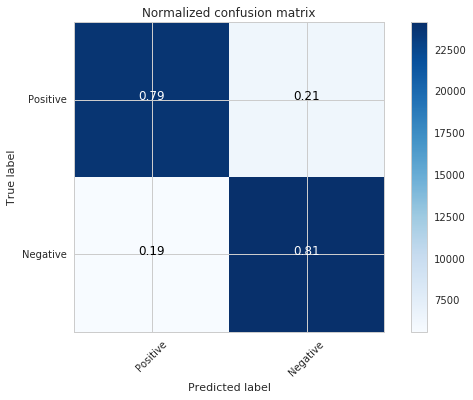

In [17]:
plot_confusion_matrix(Log_matrix, classes=["Positive","Negative"], normalize=True, title='Normalized confusion matrix')

Normalized confusion matrix
[[ 0.7197917   0.2802083 ]
 [ 0.14853774  0.85146226]]


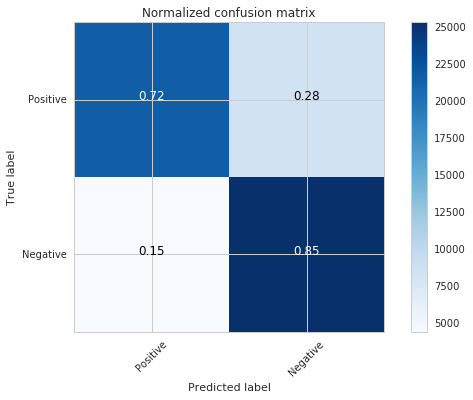

In [18]:
plot_confusion_matrix(MNB_matrix, classes=["Positive","Negative"], normalize=True,  title='Normalized confusion matrix')

Print the metrics of the performance of the algorithms

In [19]:
X_test_new_Log=[]
X_test_new_MNB=[]
y_new=[]
Log_list=predicted_Log.tolist()
MNB_list=predicted_MNB.tolist()
for x in Log_list:
    X_test_new_Log.append(int(x))
for x in MNB_list:
    X_test_new_MNB.append(int(x))
for x in y_test:
    y_new.append(int(x))


Log_list_prediction=[1 if x==4 else x for x in X_test_new_Log]
MNB_list_prediction=[1 if x==4 else x for x in X_test_new_MNB]
target_new=[1 if x==4 else x for x in y_new]

print('Metrics Logistic Regression')
print('-------------------------------------')
print("Accuracy:",accuracy_score(target_new, Log_list_prediction))
print("Recall:",recall_score(target_new,Log_list_prediction))
print("Precision:",precision_score(target_new, Log_list_prediction))
print("F1 Score:",f1_score(target_new, Log_list_prediction))
print('' '')
print('Metrics Multinomial Naive Bayes')
print('-------------------------------------')
print("Accuracy:",accuracy_score(target_new, MNB_list_prediction))
print("Recall:",recall_score(target_new,MNB_list_prediction))
print("Precision:",precision_score(target_new, MNB_list_prediction))
print("F1 Score:",f1_score(target_new, MNB_list_prediction))

Metrics Logistic Regression
-------------------------------------
Accuracy: 0.800083333333
Recall: 0.789711101529
Precision: 0.808070866142
F1 Score: 0.798785499807

Metrics Multinomial Naive Bayes
-------------------------------------
Accuracy: 0.7853
Recall: 0.719791701217
Precision: 0.83034245265
F1 Score: 0.771125008884


ROC Curves

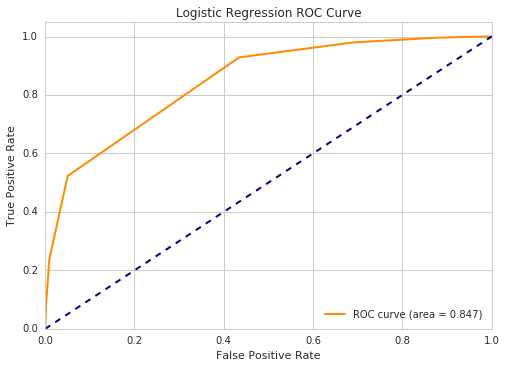

In [20]:
predicted_Log_new=[]
y_actual=[]
for x in dec_Log:
    predicted_Log_new.append(int(x))
for x in y_test:
    y_actual.append(int(x))

Log_list_prediction=[1 if x==4 else x for x in predicted_Log_new]
target_new=[1 if x==4 else x for x in  y_actual]

fpr, tpr, thresholds=roc_curve(target_new, Log_list_prediction, pos_label=1)
roc_auc= auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.3f)' % roc_auc )
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression ROC Curve')
plt.legend(loc="lower right")
plt.show()
plt.savefig('Log_roc.jpg')

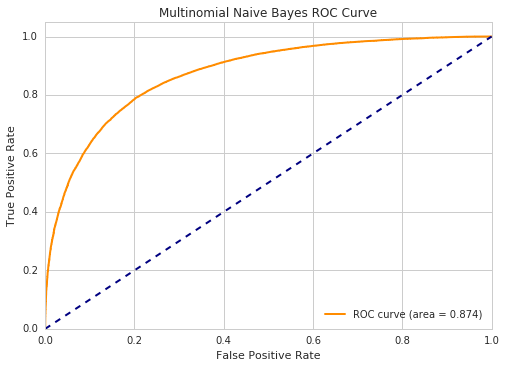

In [21]:
predicted_MNB_new=[]
y_actual=[]
for x in range(0,60000):
    predicted_MNB_new.append(dec_MNB[x][1])
#for x in dec_MNB:
#    predicted_MNB_new.append(int(x))
for x in y_test:
    y_actual.append(int(x))

#MNB_list_prediction=[1 if x==4 else x for x in predicted_MNB_new]
target_new=[1 if x==4 else x for x in  y_actual]

fpr, tpr, thresholds=roc_curve(target_new, predicted_MNB_new)
roc_auc= auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.3f)' % roc_auc )
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multinomial Naive Bayes ROC Curve')
plt.legend(loc="lower right")
plt.show()
plt.savefig('MNB_roc.jpg')

## Predict on unclassified data

In [22]:
with open("/resources/data/unclassified_tweets.txt", "r",encoding="utf8") as myfile:
     unclass_data = myfile.readlines()

Predict sentiment

In [23]:
MNB_clf = MNB_clf.fit(X_train, y_train)
predicted_MNB_unclass =MNB_clf.predict(unclass_data)

#### Categorize data by political party

In [24]:
def party(tw):
    """For NDP is chosen the name of the candidate of that party in various forms and its campaign slogan
        For Liberals is chosen the name of the candidate of that party in various forms and its campaign slogan
        For Conservatives was chosen the name of the candidate of that partym and associations related with the party (tcot,ccot),
            nickname used by them (like tory) and the bill that was inroduced by the conservative government (c51)"""
    tw_clean=tw.split()
    hashtags=[]
    NDP_list=['tommulcair','mulcair','ndp','tm4pm', 'ready4change','thomasmulcair']
    Lib_list=['justin', 'trudeau\'s','lpc','trudeau','realchange','liberal','liberals','justintrudeau','teamtrudeau']
    Cons_list=['c51','harper','cpc','conservative', 'tory','tcot','stephenharper','ccot','harper','conservatives']
    for x in range(0,len(tw_clean)):
        if tw_clean[x].find('#')!= -1:
            hashtags.append(tw_clean[x].replace('#',''))
    result=''
    if hashtags:
        for x in hashtags:
            if x in NDP_list:
                result= 'NDP'
                return result
            elif x in Lib_list:
                result= 'Liberal'
                return result
            elif x in Cons_list:
                result= 'Conservative'
                return result
    if result=='':
        result='Other'
        return result

In [25]:
party_af=[]
for x in range(0,len(unclass_data)):
    party_af.append(party(unclass_data[x]))

#### Put data into a dataframe

In [26]:
predictions=[]
for x in range(0,len(unclass_data)):
    predictions.append((unclass_data[x],party_af[x],predicted_MNB_unclass[x]))
tweets=pd.DataFrame(predictions, columns=["Tweet","Party","Classification - MNB"])
tweets.head()

,Tweet,Party,Classification - MNB
0,﻿living the dream. #cameraman #camera #camerac...,Other,0
1,justin #trudeau's reasons for thanksgiving. to...,Liberal,4
2,@themadape butt…..butt…..we’re allergic to l...,Other,4
3,2 massive explosions at peace march in #turkey...,Other,4
4,#mulcair suggests there’s bad blood between hi...,NDP,4


In [27]:
def get_sent(tweet):
    classf = tweet
    return 'Positive' if classf=='4' else 'Negative'
tweets_clean= tweets[tweets.Party !="Other"]
tweets_clean['Sentiment'] = tweets_clean['Classification - MNB'].apply(get_sent)
tweets_clean.drop(labels=['Classification - MNB'], axis=1, inplace=True)
tweets_clean.head()

/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,Tweet,Party,Sentiment
1,justin #trudeau's reasons for thanksgiving. to...,Liberal,Positive
4,#mulcair suggests there’s bad blood between hi...,NDP,Positive
5,#polqc on se sort de la marde avec #harper et ...,Conservative,Positive
16,#ready4change #ndp #tm4pm fb.me/53nxi25ue \n,NDP,Negative
17,can you believe the guy who vows to spiral can...,Liberal,Negative


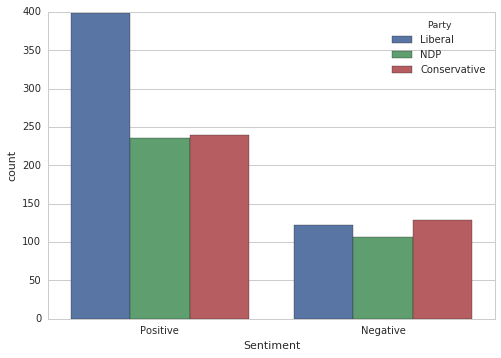

In [28]:
sns.countplot(x='Sentiment', hue="Party", data=tweets_clean)

#### Get some information about the predictions

In [29]:
print ("Number of tweets of classfied for each party")
tweets_clean.Party.value_counts().head()

Number of tweets of classfied for each party


Liberal         520
Conservative    368
NDP             343
Name: Party, dtype: int64

In [30]:
print ("Number of tweets of classfied for each party")
tweets_clean[tweets_clean.Sentiment=='Positive'].Party.value_counts().head()

Number of tweets of classfied for each party


Liberal         398
Conservative    239
NDP             236
Name: Party, dtype: int64

In [31]:
print ("Number of tweets of classfied for each party")
tweets_clean[tweets_clean.Sentiment=='Negative'].Party.value_counts().head()

Number of tweets of classfied for each party


Conservative    129
Liberal         122
NDP             107
Name: Party, dtype: int64